In [1]:
from sys import warnoptions
from warnings import simplefilter
if not warnoptions: simplefilter(action = 'ignore', category = FutureWarning)

import os
import numpy as np
from time import time
from PIL import Image
from sklearn import svm
from sklearn.externals import joblib
from keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt


from Dataset import create_dataset, save
from Dataset import make_squares, linearize_masks

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1)
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


In [2]:
#Dataset Creation (Only 1 Image)
X, y = create_dataset(image_dir_path='./TestData', remove=['OASIS', 'LPBA40'])


Reading Images and Masks:
Images: ['IBSR']
Masks: ['IBSR']


In [3]:
image_shape = X[0].shape
depth_index = -1
pixels_for_sheet = -1

if image_shape[1] == image_shape[2]:
    depth_index = 0
    pixels_for_sheet = (image_shape[1] - 53)**2
elif image_shape[0] == image_shape[2]:
    depth_index = 1
    pixels_for_sheet = (image_shape[0] - 53)**2
elif image_shape[0] == image_shape[1]:
    depth_index = 2
    pixels_for_sheet = (image_shape[0] - 53)**2

    
begin = time()
#Processing image Sheet-by-Sheet (RAM-Memory Limitations)
for sheet_index in range(86, image_shape[depth_index]):
    #parcial_begin = time()
    
    if depth_index == 0:
        sheet = X[0][sheet_index,:,:,:]
    elif depth_index == 1:
        sheet = X[0][:,sheet_index,:,:]
    elif depth_index == 2:
        sheet = X[0][:,:,sheet_index,:]
    
    #Squaring Sheet
    print("Squaring sheet %d: " % (sheet_index))
    squared_sheet = make_squares([sheet], step=[1,1,1], four_dimensions=False)
    print("\nSquaring Complete\n")
    
    #Transforming X=(Numpy Arrays) to Xpil=(PIL Images)
    print("Transforming into 'RGB Squares': ")
    SquaresPil = []
    for image in squared_sheet:
        tmp = image/np.abs(image.max())
        tmp *= (255.0/tmp.max())
        SquaresPil.append(Image.fromarray(np.uint8(tmp)))
    squared_sheet = 0
    #Reshaping PIL Images
    SquaresReshaped = []
    for image in SquaresPil:
        SquaresReshaped.append(image.resize(size=(224,224)))
    SquaresPil = 0
    #Returning to Numpy Arrays
    SquaresFinal = []
    for image in SquaresReshaped:
        SquaresFinal.append(np.asarray(image))
    SquaresReshaped = 0
    print("RGB Transformation Complete")
    
    #Saving Edited Dataset (Impracticable for storage Limitations)
    #save(SquareFinal, 'X_predict_total', sheet=sheet_index, pixels_in_sheet=pixels_for_sheet)
    
    #parcial_end = time()
    #print("\nParcial Time: " + str(parcial_end - parcial_begin), end='\n\n')
    
    break

end = time()
print("\n\nProcess Terminated!\nTotal time: " + str(end - begin))

Squaring sheet 86: 

Creating Squares:
Number of Images: 1
Image 01 ---------------> Loaded
Process Successfully Terminated
Number of lines: 65536
Total Time: 2.928979

Squaring Complete

Transforming into 'RGB Squares': 
RGB Transformation Complete


Process Terminated!
Total time: 39.689215660095215


In [4]:
#Transforming List into NumpyArray
array_transform_begin = time()

num_of_squares = len(SquaresFinal)
squares_array = np.zeros((num_of_squares, 224, 224, 3), dtype='int8')

for index in range(num_of_squares):
    squares_array[index,:,:,:] = SquaresFinal[index]
    SquaresFinal[index] = 0

SquaresFinal = 0
array_transform_end = time()

total_time = array_transform_end - array_transform_begin
print("Transformation 'List to Array' Time (1 Sheet): " + str(total_time))

Transformation 'List to Array' Time (1 Sheet): 5.826500415802002


In [5]:
#Base Model Creation
base_model = ResNet50(weights='imagenet', 
                 input_shape=(224,224,3),
                 include_top=False)

#Generation of Base Features
base_features_begin = time()
resnet50features = base_model.predict(squares_array)
resnet50features = np.reshape(resnet50features,(resnet50features.shape[0],-1))
squares_array = 0
base_features_end = time()

print("Features Generation Time (1 Sheet): " + str(base_features_end - base_features_begin))

Features Generation Time (1 Sheet): 216.4461190700531


In [6]:
#Trained SVC Load
model = joblib.load('trained_svc_model.pk1')

#Sheet Prediction
pred_begin = time()
y_pred = model.predict(resnet50features)
pred_end = time()

print("Total Prediction Time (1 Sheet): " + str(pred_end - pred_begin))

Total Prediction Time (1 Sheet): 948.7604672908783


In [7]:
y_expected = linearize_masks(y, step=[1,1,1], two_classes=False)
y_expected = y_expected[62*len(y_pred):63*len(y_pred)]


Linearizing Masks:
Number of Masks: 1
Image 01 ---------------> Loaded
Process Successfully Terminated
Number of lines: 8388608
Total Time: 3.409830


In [8]:
#Probabilistic Comparison
assert len(y_pred) == len(y_expected)

positive, negative = 0, 0
for num in y_pred:
    if num: 
        positive += 1
    else: 
        negative += 1

true_pos, true_neg = 0,0
false_pos, false_neg = 0,0
for index in range(len(y_pred)):
    if y_pred[index]*(-1) == y_expected[index]:
        if y_pred[index] == -1:
            true_pos += 1
        else:
            true_neg += 1
    else:
        if y_pred[index] == -1:
            false_pos += 1
        else:
            false_neg += 1
            
accuracy = (true_pos + true_neg) / len(y_pred)
loss = (false_pos + false_neg) / len(y_pred)

positive = 1 if positive == 0 else positive
porc_pos = positive / len(y_pred) * 100

negative = 1 if negative == 0 else negative
porc_neg = negative / len(y_pred) * 100

print()
print("Acurracy: %.2f%%" % (accuracy * 100))
print("Loss: %.2f%%" % (loss * 100))
print()
print("Positives: %d predictions (%.2f%% of Total)" % (positive, porc_pos))
print("True_Positive: %.2f%%" % (true_pos / positive * 100))
print("False_Positive: %.2f%%" % (false_pos / positive * 100))
print()
print("Negatives: %d predictions (%.2f%% of Total)" % (negative, porc_neg))
print("True_Negative: %.2f%%" % (true_neg / negative * 100))
print("False_Negative: %.2f%%" % (false_neg / negative * 100))


Acurracy: 91.68%
Loss: 8.32%

Positives: 18815 predictions (28.71% of Total)
True_Positive: 71.04%
False_Positive: 28.96%

Negatives: 46721 predictions (71.29% of Total)
True_Negative: 99.99%
False_Negative: 0.01%


In [9]:
#Linearization of the Predicted Sheet and the Expected Result
if not depth_index == 0:
    axis_length = image_shape[0] - 53
else:
    axis_length = image_shape[1] - 53

assert axis_length**2 == len(y_pred)

pred_sheet = np.zeros((axis_length, axis_length), dtype='int8')
for height in range(axis_length):
    for width in range(axis_length):
        pred_sheet[width, height] = y_pred[height*axis_length + width]*(-1)

expec_sheet = np.zeros((axis_length, axis_length), dtype='int8')
for height in range(axis_length):
    for width in range(axis_length):
        expec_sheet[width, height] = y_expected[height*axis_length + width]




In [16]:
pred_to_plot = np.rot90(pred_sheet)
plt.imshow(pred_to_plot, cmap='gray')
plt.imsave('./predicted.png', pred_to_plot, cmap='gray')

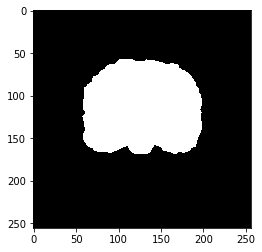

In [17]:
expec_to_plot = np.rot90(expec_sheet)
plt.imshow(expec_to_plot, cmap='gray')
plt.imsave('./expected.png', expec_to_plot, cmap='gray')

In [49]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title, fontsize=19, va='bottom')
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    fig.savefig('./composite.png', cmap='gray')

In [29]:
img = [expec_to_plot, pred_to_plot]
ttl = ['Máscara Esperada', 'Resultado Obtido']

In [50]:
show_images(img, titles=ttl)